In [13]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tushare as ts
sns.set_style('whitegrid')  # Give nice white background with grid
%matplotlib inline


In [2]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as dt
 
def pandas_candlestick_ohlc(dat, figsize=(12,8),stick = "day", otherseries = None,):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots(figsize=figsize)
    
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(dt.date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()

In [16]:
changan=pd.read_csv('../data/changan.csv',index_col='date',parse_dates=True)
changan.sort_index(ascending=True,inplace=True)
changan.head()

,open,high,close,low,volume,amount
date,,,,,,
2016-01-04,16.16,16.16,14.70,14.65,35583232.0,574888896.0
2016-01-05,14.52,15.21,14.87,14.36,48751992.0,757602560.0
2016-01-06,14.99,15.43,15.43,14.93,35700748.0,568087936.0
2016-01-07,15.26,15.26,14.21,14.14,9646493.0,148764560.0
2016-01-08,14.62,15.06,14.94,14.32,42356156.0,654564864.0


In [17]:
changan.columns=['Open','High','Close','Low','Volume','Amount']

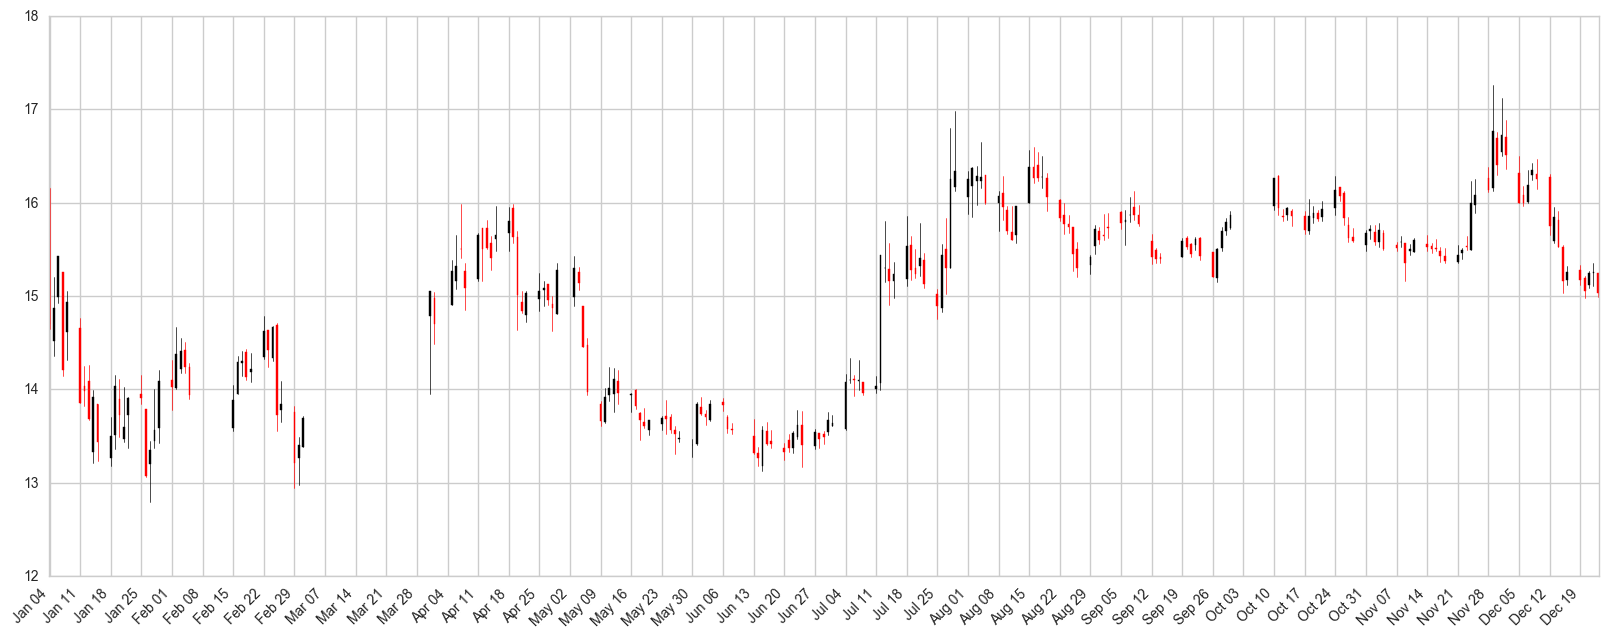

In [18]:
pandas_candlestick_ohlc(changan,figsize=(20,8))

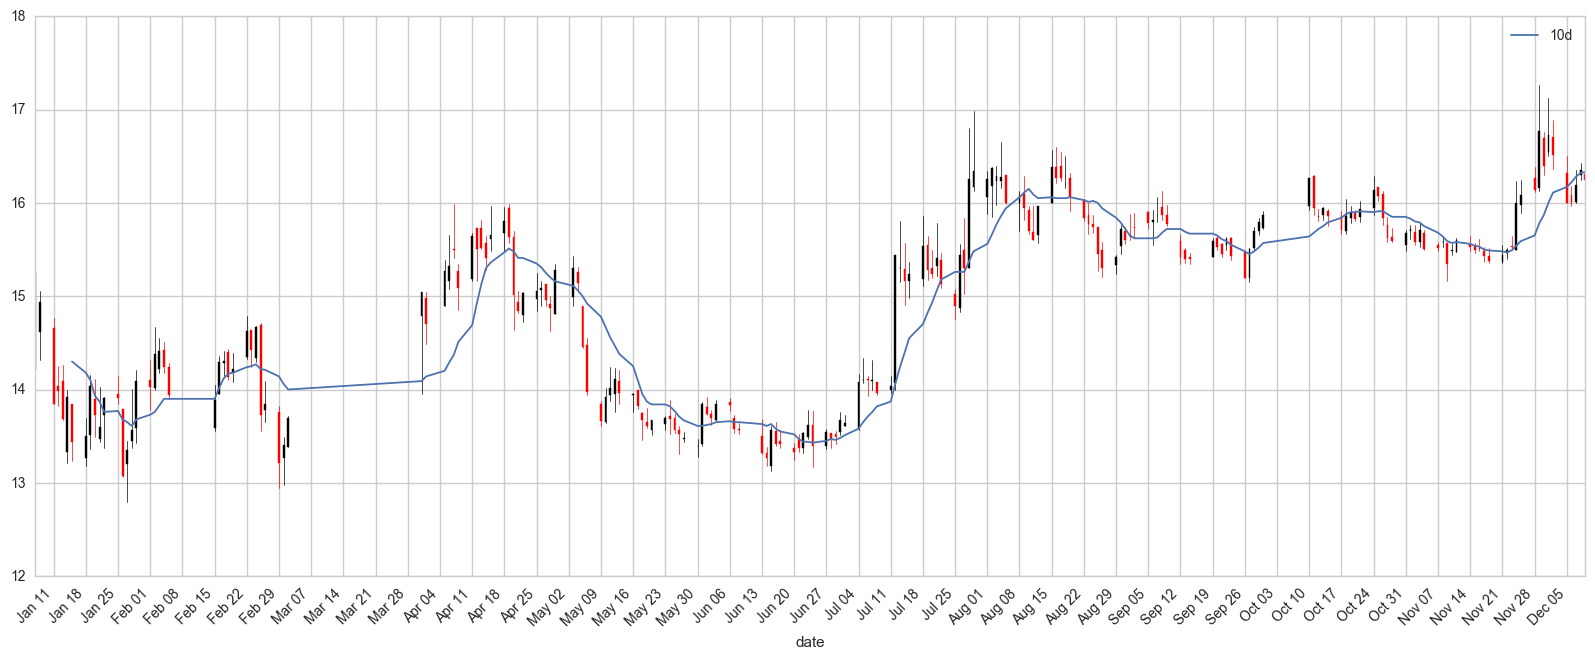

In [8]:
changan["10d"] = np.round(changan["Close"].rolling(window = 10, center = False).mean(), 2)
pandas_candlestick_ohlc(changan.loc['2016-1-7':'2016-12-10',:], figsize=(20,8),otherseries = "10d")

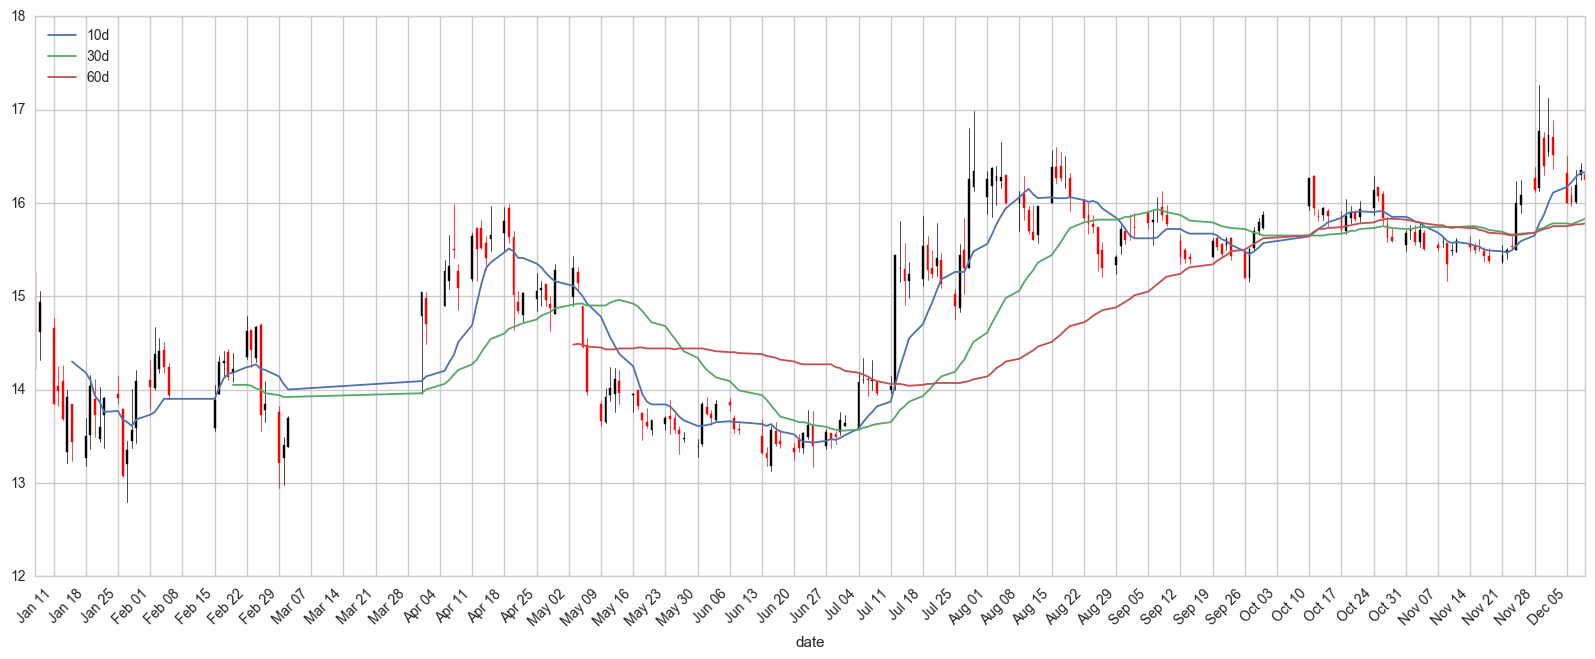

In [10]:
changan["30d"] = np.round(changan["Close"].rolling(window = 30, center = False).mean(), 2)
changan["60d"] = np.round(changan["Close"].rolling(window = 60, center = False).mean(), 2)
 
pandas_candlestick_ohlc(changan.loc['2016-01-07':'2016-12-10',:], figsize=(20,8),otherseries = ["10d", "30d", "60d"])
